<h2>Text based Sentiment Analysis using LSTM Model (Semi-supervised Learning)</h2>

<h3>Importing Modules</h3>

In [2]:
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from keras.utils import to_categorical, plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Dropout, LSTM, Embedding
from keras.models import Sequential, Model
from keras.optimizers import Adam

import nltk
from nltk.corpus import stopwords

<h3>Data Extraction</h3>

In [3]:
df = pd.read_csv("tweet_emotions.csv")
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


The dataset is collected in CSV format from <b>Kaggle</b>. The dataset contains the tweets along with the sentiment labels. The read_csv() function from <i>pandas</i> is used for data extraction.

<h3>Exploratory Data Analysis</h3>

In [4]:
df.shape, df.size

((40000, 3), 120000)

The total number of samples are 40K with total of 3 features

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


The total columns are 3 with two types of data i.e. int64 (tweet_id) and objects (sentiment and content)

In [6]:
df.describe()

,tweet_id
count,4.000000e+04
mean,1.845184e+09
std,1.188579e+08
min,1.693956e+09
25%,1.751431e+09
50%,1.855443e+09
75%,1.962781e+09
max,1.966441e+09


In [7]:
df.columns

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

In [8]:
df.nunique()

tweet_id     40000
sentiment       13
content      39827
dtype: int64

The tweet_id is all unique with 40K values while sentiment labels are 13.

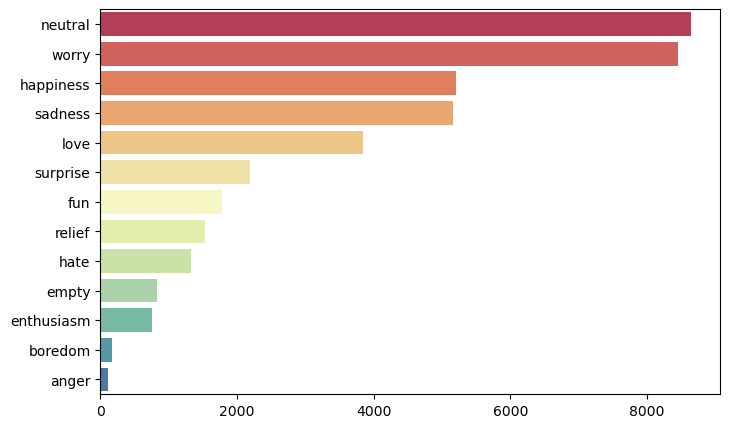

In [9]:
sentiment_counts = df['sentiment'].value_counts()

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=sentiment_counts.values, y=sentiment_counts.index, orient="h", ax=ax, palette="Spectral")
plt.show()

<h3>Data Preprocessing</h3>

<h4>1. Validation and Cleansing</h4>

In [10]:
df.isna().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [11]:
# df.dropna(inplace=True)

In [12]:
df.duplicated().sum()

0

In [13]:
# df.drop_duplicates(inplace=True)

In [14]:
# converting the each text in content column in lowercase
df['content'] = df['content'].str.lower()
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends soon!
4,1956968416,neutral,@dannycastillo we want to trade with someone w...


In [15]:
# removing punctuations
df['content'] = df['content'].str.translate(str.maketrans('','', string.punctuation))
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,tiffanylue i know i was listenin to bad habit...
1,1956967666,sadness,layin n bed with a headache ughhhhwaitin on y...
2,1956967696,sadness,funeral ceremonygloomy friday
3,1956967789,enthusiasm,wants to hang out with friends soon
4,1956968416,neutral,dannycastillo we want to trade with someone wh...


<h4>2. Tokenization: Word-based</h4>

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Neurons\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
texts = df['content'].to_numpy()

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)

In [18]:
vocab = tokenizer.word_index
vocab

{'i': 1,
 'to': 2,
 'the': 3,
 'a': 4,
 'my': 5,
 'and': 6,
 'you': 7,
 'it': 8,
 'is': 9,
 'in': 10,
 'for': 11,
 'of': 12,
 'im': 13,
 'on': 14,
 'me': 15,
 'have': 16,
 'so': 17,
 'that': 18,
 'but': 19,
 'just': 20,
 'day': 21,
 'with': 22,
 'be': 23,
 'its': 24,
 'at': 25,
 'was': 26,
 'not': 27,
 'all': 28,
 'good': 29,
 'this': 30,
 'now': 31,
 'out': 32,
 'up': 33,
 'get': 34,
 'like': 35,
 'are': 36,
 'no': 37,
 'go': 38,
 'dont': 39,
 'do': 40,
 'your': 41,
 'got': 42,
 'love': 43,
 'too': 44,
 'work': 45,
 'today': 46,
 'going': 47,
 'cant': 48,
 'happy': 49,
 'from': 50,
 'one': 51,
 'time': 52,
 'lol': 53,
 'know': 54,
 'back': 55,
 'what': 56,
 'u': 57,
 'will': 58,
 'really': 59,
 'about': 60,
 'we': 61,
 'am': 62,
 'see': 63,
 'had': 64,
 'there': 65,
 'can': 66,
 'some': 67,
 'mothers': 68,
 'well': 69,
 'if': 70,
 'new': 71,
 'night': 72,
 'home': 73,
 'think': 74,
 'as': 75,
 'want': 76,
 'when': 77,
 'thanks': 78,
 'how': 79,
 'amp': 80,
 'oh': 81,
 'still': 82,
 'o

In [19]:
vocab_size = len(vocab) + 1
vocab_size

53745

In [20]:
tokenized_texts = [text.split() for text in texts]
np.array(tokenized_texts[0])

array(['tiffanylue', 'i', 'know', 'i', 'was', 'listenin', 'to', 'bad',
       'habit', 'earlier', 'and', 'i', 'started', 'freakin', 'at', 'his',
       'part'], dtype='<U10')

Text(0.5, 1.0, 'Histogram Plot For Text Length')

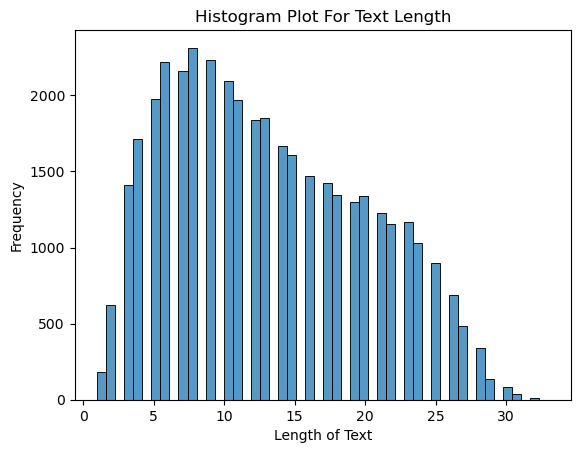

In [21]:
word_counts = [len(seq) for seq in tokenized_texts]

sns.histplot(data=word_counts,)
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Histogram plot for text length'.title())

<h4>Stopwords Removal</h4>

In [22]:
stop_words = set(stopwords.words("english"))
filtered_texts = [[token for token in tokenized_text if token.lower() not in stop_words] for tokenized_text in tokenized_texts]
np.array(filtered_texts[0])

array(['tiffanylue', 'know', 'listenin', 'bad', 'habit', 'earlier',
       'started', 'freakin', 'part'], dtype='<U10')

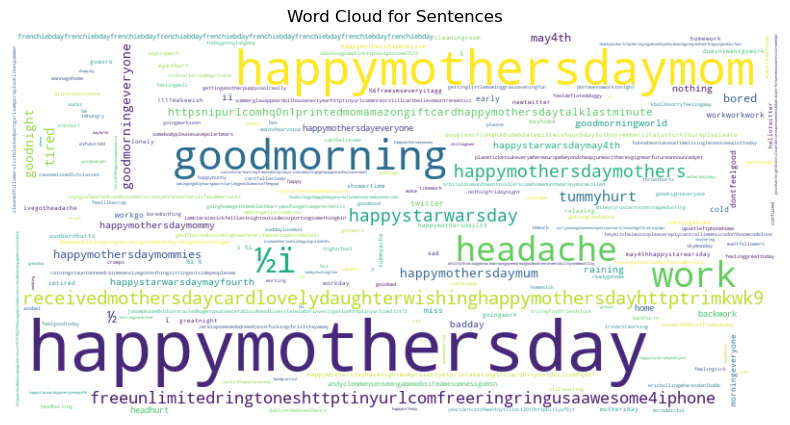

In [23]:
from wordcloud import WordCloud

all_text = ' '.join([''.join(seq) for seq in filtered_texts])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.title('Word Cloud for Sentences')
plt.show()

In [24]:
sequences = tokenizer.texts_to_sequences(filtered_texts)
sequences[0]

[54, 3127, 118, 802, 578, 1104, 519]

In [25]:
df['tokenized_content'] = np.array(sequences, dtype="object")

In [26]:
len(df['tokenized_content'][2]), len(df['tokenized_content'][17]), len(df['tokenized_content'][0])

(2, 4, 7)

<h4>3. Padding and Sequences</h4>

In [27]:
max_sequence_length = max([len(seq) for seq in df['tokenized_content']])
max_sequence_length

23

In [28]:
padded_content = pad_sequences(df['tokenized_content'], padding="post", maxlen=max_sequence_length)
df['padded_content'] = pd.Series(padded_content.tolist())
df.head()

,tweet_id,sentiment,content,tokenized_content,padded_content
0,1956967341,empty,tiffanylue i know i was listenin to bad habit...,"[54, 3127, 118, 802, 578, 1104, 519]","[54, 3127, 118, 802, 578, 1104, 519, 0, 0, 0, ..."
1,1956967666,sadness,layin n bed with a headache ughhhhwaitin on y...,"[307, 145, 415, 278]","[307, 145, 415, 278, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,1956967696,sadness,funeral ceremonygloomy friday,"[2768, 228]","[2768, 228, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,1956967789,enthusiasm,wants to hang out with friends soon,"[416, 671, 187, 164]","[416, 671, 187, 164, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,1956968416,neutral,dannycastillo we want to trade with someone wh...,"[76, 3128, 244, 2468, 611, 51]","[76, 3128, 244, 2468, 611, 51, 0, 0, 0, 0, 0, ..."


In [29]:
len(df['padded_content'][2]), len(df['padded_content'][17]), len(df['padded_content'][0])

(23, 23, 23)

<h4>4. Encoding for Target Class i.e. Sentiment</h4>

In [30]:
label_encoder = LabelEncoder()

df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df.head()

,tweet_id,sentiment,content,tokenized_content,padded_content
0,1956967341,2,tiffanylue i know i was listenin to bad habit...,"[54, 3127, 118, 802, 578, 1104, 519]","[54, 3127, 118, 802, 578, 1104, 519, 0, 0, 0, ..."
1,1956967666,10,layin n bed with a headache ughhhhwaitin on y...,"[307, 145, 415, 278]","[307, 145, 415, 278, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,1956967696,10,funeral ceremonygloomy friday,"[2768, 228]","[2768, 228, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,1956967789,3,wants to hang out with friends soon,"[416, 671, 187, 164]","[416, 671, 187, 164, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,1956968416,8,dannycastillo we want to trade with someone wh...,"[76, 3128, 244, 2468, 611, 51]","[76, 3128, 244, 2468, 611, 51, 0, 0, 0, 0, 0, ..."


In [31]:
labels = label_encoder.classes_

labels

array(['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
       'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
       'worry'], dtype=object)

<h4>5. Word Embedding</h4>

The provided code introduces the following variables:

- <strong>path_to_glove_file</strong>: This variable contains the file path to the GloVe word vectors file.

- <strong>num_tokens</strong>: It represents the size of the vocabulary, typically indicating the number of unique words in the dataset.

- <strong>embedding_dim</strong>: The dimensionality of the word vectors, usually set to a fixed value (e.g., 200, 300, etc.) based on the size of the word vectors file used.

- <strong>hits</strong>: A counter that keeps track of the number of words found in the embeddings_index dictionary.

- <strong>misses</strong>: A counter that records the number of words not found in the embeddings_index dictionary.

- <strong>embeddings_index</strong>: This dictionary serves as a storage container for word vectors. It uses words as keys and corresponding word vectors as values.

In [32]:
# Read GloVE embeddings
glove_filepath = 'glove.6B/glove.6B.200d.txt'

embedding_dim = 200 
hits = 0
misses = 0
embeddings_index = {}

In [33]:
# Read word vectors
with open(glove_filepath, encoding='utf-8') as file:
    for line in file:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")

Found 400000 word vectors.
Converted 21898 words (31846 misses)


<h4>6. Data Normalization</h4>

In [34]:
tokens_dist = list(vocab.values())

min_val = np.min(tokens_dist)
max_val = np.max(tokens_dist)

min_val, max_val

(1, 53744)

In [35]:
# df['padded_content'] = [np.round((np.array(seq) - min_val)/(max_val - min_val), 4) for seq in df['padded_content']]

# df.head(5)

<h4>7. Splitting into Labeled, and Unlabeled</h4>

In [36]:
X, y = df['padded_content'], df['sentiment']

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, train_size=0.2, random_state=1024)

X_labeled_train, X_labeled_test, y_labeled_train, y_labeled_test = train_test_split(X_labeled, y_labeled, test_size=0.1)

In [37]:
X_labeled.shape, X_unlabeled.shape, X_labeled_train.shape, X_labeled_test.shape

((8000,), (32000,), (7200,), (800,))

In [38]:
X_labeled_train = np.array([x for x in X_labeled_train])
X_labeled_test = np.array([x for x in X_labeled_test])

X_unlabeled = np.array([x for x in X_unlabeled])

In [39]:
X_unlabeled.shape, X_labeled_train.shape, X_labeled_test.shape

((32000, 23), (7200, 23), (800, 23))

In [40]:
y_labeled_train = to_categorical(y_labeled_train)
y_labeled_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

<h3>Model Analysis using LSTM </h3>

In [41]:
def LSTM_Model():
    
    input_layer = Input(shape=(max_sequence_length,))
    x = Embedding(input_dim = vocab_size, output_dim = embedding_dim)(input_layer)
    
    x = LSTM(units=128, return_sequences=True)(x)
    x = Dropout(0.5)(x)
    x = LSTM(units=64)(x)
    x = Dropout(0.5)(x)

    output_layer = Dense(units=len(labels), activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model


In [42]:
model = LSTM_Model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 embedding (Embedding)       (None, 23, 200)           10749000  
                                                                 
 lstm (LSTM)                 (None, 23, 128)           168448    
                                                                 
 dropout (Dropout)           (None, 23, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 13)                845   

In [43]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=4,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore weights from the epoch with the best validation performance
)

In [44]:
# supervised learning 
history = model.fit(X_labeled_train, y_labeled_train, epochs=10, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
51/51 [==============================] - 19s 247ms/step - loss: 2.2553 - accuracy: 0.2022 - val_loss: 2.1363 - val_accuracy: 0.2389
Epoch 2/10
51/51 [==============================] - 11s 211ms/step - loss: 2.1842 - accuracy: 0.2162 - val_loss: 2.1200 - val_accuracy: 0.2347
Epoch 3/10
51/51 [==============================] - 11s 214ms/step - loss: 2.0956 - accuracy: 0.2432 - val_loss: 2.0504 - val_accuracy: 0.2583
Epoch 4/10
51/51 [==============================] - 11s 216ms/step - loss: 1.9298 - accuracy: 0.3218 - val_loss: 2.0577 - val_accuracy: 0.3028
Epoch 5/10
51/51 [==============================] - 11s 210ms/step - loss: 1.7577 - accuracy: 0.3904 - val_loss: 2.0886 - val_accuracy: 0.2806
Epoch 6/10
51/51 [==============================] - 11s 219ms/step - loss: 1.6222 - accuracy: 0.4560 - val_loss: 2.2513 - val_accuracy: 0.2681
Epoch 7/10
51/51 [==============================] - 11s 214ms/step - loss: 1.4892 - accuracy: 0.5083 - val_loss: 2.3362 - val_accuracy: 0.2611

In [45]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

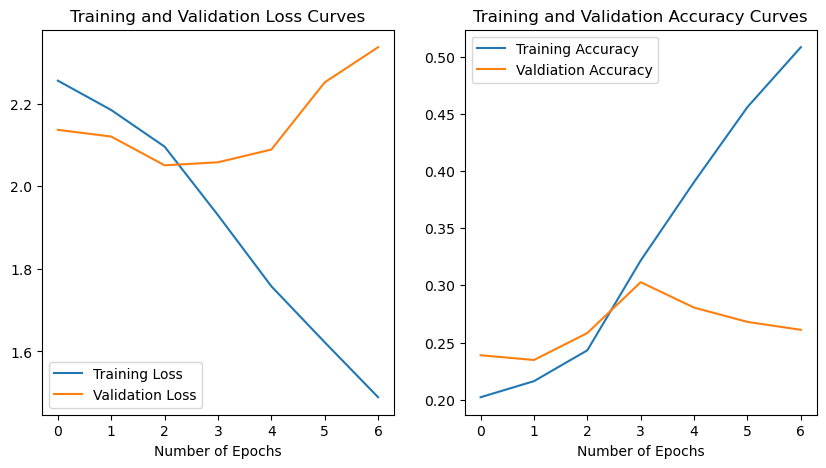

In [46]:
# Training and Validation Loss Curves and Accuracy Curves
curves = ['loss', 'accuracy']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, curve in enumerate(curves):
    if curve == "loss":
        sns.lineplot(train_loss, ax=axes[i], label="Training Loss")
        sns.lineplot(val_loss, ax=axes[i], label="Validation Loss")
        axes[i].set_title("Training and Validation Loss Curves")
        
    if curve == "accuracy":
        sns.lineplot(train_acc, ax=axes[i], label="Training Accuracy")
        sns.lineplot(val_acc, ax=axes[i], label="Valdiation Accuracy")
        
        axes[i].set_title("Training and Validation Accuracy Curves")
    
    axes[i].set_xlabel("Number of Epochs")
    
    axes[i].legend()

In [47]:
num_epochs = 7

for epoch in range(num_epochs):
    pseudo_labels = model.predict(X_unlabeled)
    
    threshold_accuracy = 0.9
    pseudo_indices = np.where(np.argmax(pseudo_labels, axis=1) > threshold_accuracy)[0]
    
    X_sel = X_unlabeled[pseudo_indices]
    y_sel = pseudo_labels[pseudo_indices]
    
    X_com = np.vstack([X_labeled_train, X_sel])
    y_com = np.vstack([y_labeled_train, y_sel])
    
    model.fit(X_com, y_com, batch_size=1024, verbose=1)

39/39 [==============================] - 30s 773ms/step - loss: 2.0183 - accuracy: 0.7043


In [48]:
y_preds = model.predict(X_labeled_test)
y_preds = np.argmax(y_preds, axis=1)

25/25 [==============================] - 0s 13ms/step


In [49]:
yp_train = model.predict(X_labeled_train)
yp_train = np.argmax(yp_train, axis=1)

225/225 [==============================] - 3s 14ms/step


In [50]:
train_accuracy = accuracy_score(np.argmax(y_labeled_train, axis=1), yp_train)
train_accuracy

0.41194444444444445

In [51]:
test_accuracy = accuracy_score(y_labeled_test, y_preds)
test_accuracy

0.29625

In [52]:
print(classification_report(y_labeled_test, y_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        30
           5       0.21      0.35      0.27        96
           6       0.00      0.00      0.00        25
           7       0.51      0.25      0.34        95
           8       0.33      0.56      0.41       189
           9       0.00      0.00      0.00        24
          10       0.24      0.14      0.18        93
          11       0.00      0.00      0.00        40
          12       0.32      0.37      0.34       165

    accuracy                           0.30       800
   macro avg       0.12      0.13      0.12       800
weighted avg       0.26      0.30      0.26       800



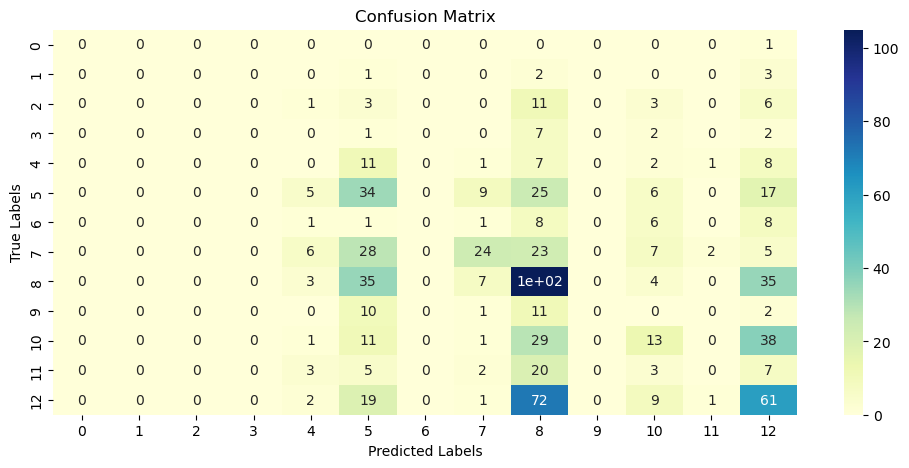

In [53]:
class_labels = np.unique(np.concatenate((y_labeled_test, y_preds)))

cm = confusion_matrix(y_labeled_test, y_preds, labels=class_labels)

plt.figure(figsize=(12, 5))
sns.heatmap(data=cm, annot=True, cmap="YlGnBu")

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


<h3>Model Analysis using RandomForestClassifier</h3>

In [54]:
y_labeled_train = np.argmax(y_labeled_train, axis=1)

In [55]:
rf = RandomForestClassifier()

rf.fit(X_labeled_train, y_labeled_train)

RandomForestClassifier()

In [56]:
yl_preds = rf.predict(X_labeled_train)

In [57]:
print(accuracy_score(y_labeled_train, yl_preds))

0.9777777777777777


In [58]:
for epoch in range(num_epochs):
    y_p = rf.predict_proba(X_unlabeled)
    
    threshold = 0.95
    indices = np.where(np.argmax(y_p, axis=1) > threshold)[0]
    
    X_sel = X_unlabeled[indices]
    y_sel = y_p[indices]
    
    X_com = np.vstack([X_labeled_train, X_sel])
    y_com = np.argmax(np.vstack([to_categorical(y_labeled_train), y_sel]), axis=1)
    
    rf.fit(X_com, y_com)
    print(f"Iteration {epoch + 1} completed.")

Iteration 1 completed.
Iteration 2 completed.
Iteration 3 completed.
Iteration 4 completed.
Iteration 5 completed.
Iteration 6 completed.
Iteration 7 completed.


In [59]:
rf_y = rf.predict(X_labeled_test)

test_acc = accuracy_score(y_labeled_test, rf_y)
test_acc

0.2425